Processing BLUELINK dataset...
Saved CEOF results to /DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_BLUELINK.pkl


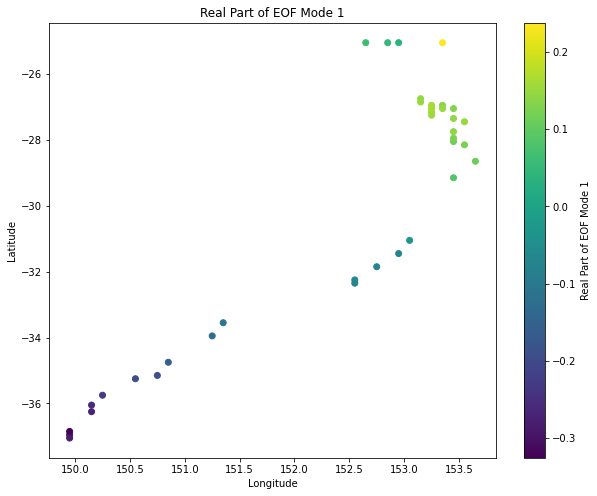

Explained Variance (%) for the first 10 modes:
Mode 1: 75.96%
Mode 2: 17.17%
Mode 3: 3.21%
Mode 4: 1.27%
Mode 5: 1.04%
Mode 6: 0.69%
Mode 7: 0.31%
Mode 8: 0.18%
Mode 9: 0.10%
Mode 10: 0.08%
Processing SWOT dataset...
Saved CEOF results to /DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_SWOT.pkl


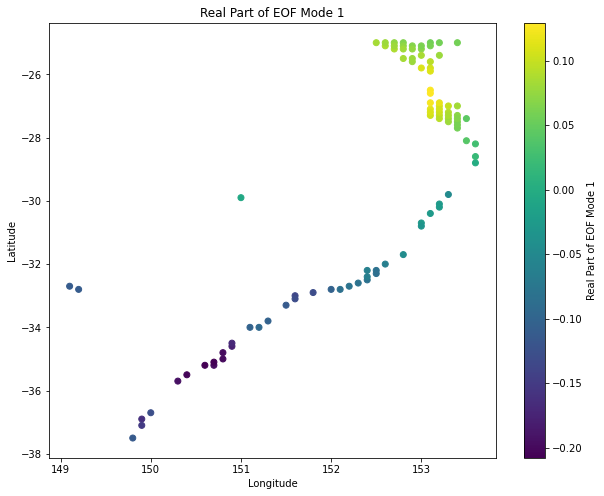

Explained Variance (%) for the first 10 modes:
Mode 1: 46.74%
Mode 2: 22.08%
Mode 3: 9.97%
Mode 4: 6.91%
Mode 5: 5.37%
Mode 6: 3.14%
Mode 7: 2.37%
Mode 8: 1.76%
Mode 9: 1.18%
Mode 10: 0.47%
Processing CMEMS dataset...
Saved CEOF results to /DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_CMEMS.pkl


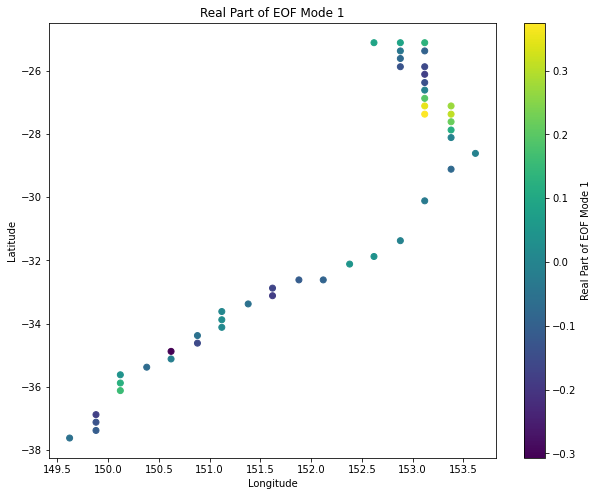

Explained Variance (%) for the first 10 modes:
Mode 1: 35.87%
Mode 2: 19.72%
Mode 3: 13.58%
Mode 4: 9.46%
Mode 5: 6.17%
Mode 6: 4.24%
Mode 7: 3.61%
Mode 8: 2.82%
Mode 9: 2.47%
Mode 10: 2.05%


In [39]:
import numpy as np
from shapely.geometry import Polygon, Point
import cartopy.feature as cfeature
import os
import re
import xarray as xr
import matplotlib.pyplot as plt
import pickle
from cartopy.io.shapereader import Reader

def extract_coastline(parallelogram):
    coastline = list(cfeature.COASTLINE.geometries())
    coastline_points = []

    for geometry in coastline:
        if geometry.intersects(parallelogram):
            if geometry.geom_type == 'LineString':
                coastline_points.extend(np.array(geometry.coords))
            elif geometry.geom_type == 'MultiLineString':
                for line in geometry:
                    coastline_points.extend(np.array(line.coords))

    coastline_points = np.array(coastline_points)

    filtered_points = np.array([point for point in coastline_points if parallelogram.contains(Point(point))])

    if len(filtered_points) > 1:
        first_point = filtered_points[0]
        last_point = filtered_points[-1]
        if last_point[1] < first_point[1] or last_point[0] < first_point[0]:
            filtered_points = filtered_points[::-1]

    return filtered_points

def filter_within_bathymetry(grid_points, gebco_file, depth_threshold=-20):
    """
    Filters grid points based on bathymetry data from a GEBCO NetCDF file.
    
    Parameters:
        grid_points (array): Array of grid points (lon, lat).
        gebco_file (str): Path to the GEBCO NetCDF file.
        depth_threshold (float): Depth threshold in meters (negative for below sea level).
        
    Returns:
        np.array: Filtered grid points within the specified bathymetry depth.
    """
    # Load the GEBCO data
    ds = xr.open_dataset(gebco_file)
    
    # Ensure longitude is in the range [0, 360] for consistency
    ds['lon'] = np.mod(ds['lon'], 360)
    
    # Adjust grid_points' longitude values for consistency
    grid_points = np.array([[lon % 360, lat] for lon, lat in grid_points])

    # Initialize an empty list to store the filtered grid points
    filtered_points = []

    # Loop over each grid point and get the bathymetry value
    for lon, lat in grid_points:
        # Interpolate bathymetry at the specific (lon, lat) point
        bathymetry_value = ds['elevation'].interp(lon=lon, lat=lat, method='nearest').values
        
        # If the bathymetry value is below the threshold, keep this point
        if bathymetry_value > depth_threshold:
            filtered_points.append([lon, lat])
    
    # Convert the filtered points list to a numpy array
    filtered_points = np.array(filtered_points)

    return filtered_points





def get_grid_points_and_files(base_dir):
    grid_points = []
    files = os.listdir(base_dir)

    for file in files:
        match = re.search(r"lat_(-?\d+\.\d+)_lon_(-?\d+\.\d+)", file)
        if match:
            lat, lon = map(float, match.groups())
            grid_points.append((lon, lat))

    return np.array(grid_points), files

def create_data_matrix(base_dir, files, grid_points, max_points=100):
    data_matrix = []
    selected_grid_points = []

    for i, file in enumerate(files[:max_points]):
        file_path = os.path.join(base_dir, file)
        ds = xr.open_dataset(file_path)
        time_series = ds['filtered_sla'].values
        data_matrix.append(time_series)
        selected_grid_points.append(grid_points[i])

    return np.array(data_matrix), np.array(selected_grid_points)

def compute_ceofs(data_matrix, num_modes=10):
    # Subtract the mean to center the data
    data_complex = data_matrix - np.mean(data_matrix, axis=0)
    
    # Perform Singular Value Decomposition (SVD)
    U, S, Vh = np.linalg.svd(data_complex, full_matrices=False)

    # Retain only the first 'num_modes' modes
    spatial_eofs = U[:, :num_modes]   # Spatial EOFs, shape (45, num_modes)
    temporal_pcs = Vh[:num_modes, :]  # Temporal PCs, shape (num_modes, 94)
    singular_values = S[:num_modes]   # Singular values, shape (num_modes,)

    return spatial_eofs, temporal_pcs, singular_values

def visualize_eof_on_map(spatial_eofs, grid_points, mode=0):
    eof_mode = spatial_eofs[:, mode]
    x = grid_points[:, 0]
    y = grid_points[:, 1]
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x, y, c=np.real(eof_mode), cmap='viridis')
    plt.colorbar(scatter, label=f'Real Part of EOF Mode {mode + 1}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Real Part of EOF Mode {mode + 1}')
    plt.show()

def save_ceof_to_pickle(output_dir, dataset_name, spatial_eofs, temporal_pcs, singular_values, grid_points):
    output_file = os.path.join(output_dir, f"ceof_{dataset_name}.pkl")

    ceof_data = {
        "spatial_eofs": spatial_eofs,
        "temporal_pcs": temporal_pcs,
        "singular_values": singular_values,
        "grid_points": grid_points
    }

    with open(output_file, 'wb') as f:
        pickle.dump(ceof_data, f)

    print(f"Saved CEOF results to {output_file}")

# Define the region of interest
parallelogram_vertices = np.array([
    [149, -38],
    [158, -38],
    [158, -25],
    [149, -25]
])
parallelogram = Polygon(parallelogram_vertices)

# Base directories
base_dirs = {
    "BLUELINK": "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK",
    "SWOT": "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_SWOT",
    "CMEMS": "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_CMEMS"
}

# Bathymetry source
gebco_file = "/DGFI8/D/topobathy/gebco2022/GEBCO_2022_sub_ice_topo.nc"


# Output directory
output_dir = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each dataset
for dataset_name, base_dir in base_dirs.items():
    print(f"Processing {dataset_name} dataset...")

    # Load grid points and corresponding files
    grid_points, files = get_grid_points_and_files(base_dir)

    # Filter grid points within the -200m bathymetry line
    filtered_grid_points = filter_within_bathymetry(grid_points, gebco_file, depth_threshold=-20)
    filtered_files = [files[i] for i, point in enumerate(grid_points) if tuple(point) in map(tuple, filtered_grid_points)]

    # Create the data matrix (subset for demo)
    data_matrix, selected_grid_points = create_data_matrix(base_dir, filtered_files, filtered_grid_points, max_points=-1)

    # Compute CEOFs and retain only the first 10 modes
    spatial_eofs, temporal_pcs, singular_values = compute_ceofs(data_matrix, num_modes=10)

    # Save to pickle
    save_ceof_to_pickle(output_dir, dataset_name, spatial_eofs, temporal_pcs, singular_values, selected_grid_points)

    # Visualize the first EOF mode on a map
    visualize_eof_on_map(spatial_eofs, selected_grid_points, mode=0)

    # Print explained variance for the first few modes
    explained_variance = (singular_values**2) / np.sum(singular_values**2) * 100
    print("Explained Variance (%) for the first 10 modes:")
    for i, var in enumerate(explained_variance[:10]):
        print(f"Mode {i + 1}: {var:.2f}%")


In [40]:
import pickle

# Define the paths to the saved CEOF files for each dataset
bluelink_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_BLUELINK.pkl"
swot_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_SWOT.pkl"
cmems_ceof_file = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/EOF_analysis/ceof_CMEMS.pkl"

# Function to load CEOF data
def load_ceof_data(ceof_file):
    with open(ceof_file, 'rb') as f:
        ceof_data = pickle.load(f)
    return ceof_data

# Load the CEOF data for each dataset
bluelink_ceof_data = load_ceof_data(bluelink_ceof_file)
swot_ceof_data = load_ceof_data(swot_ceof_file)
cmems_ceof_data = load_ceof_data(cmems_ceof_file)

# Extract the first spatial EOF and first temporal PC for each dataset
spatial_eofs_bluelink = bluelink_ceof_data['spatial_eofs']
temporal_pcs_bluelink = bluelink_ceof_data['temporal_pcs']

spatial_eofs_swot = swot_ceof_data['spatial_eofs']
temporal_pcs_swot = swot_ceof_data['temporal_pcs']

spatial_eofs_cmems = cmems_ceof_data['spatial_eofs']
temporal_pcs_cmems = cmems_ceof_data['temporal_pcs']

# Extract the first EOF mode (mode 0) for each dataset
temporal_pcs_1_bluelink = temporal_pcs_bluelink[0, :]
temporal_pcs_1_swot = temporal_pcs_swot[0, :]
temporal_pcs_1_cmems = temporal_pcs_cmems[0, :]


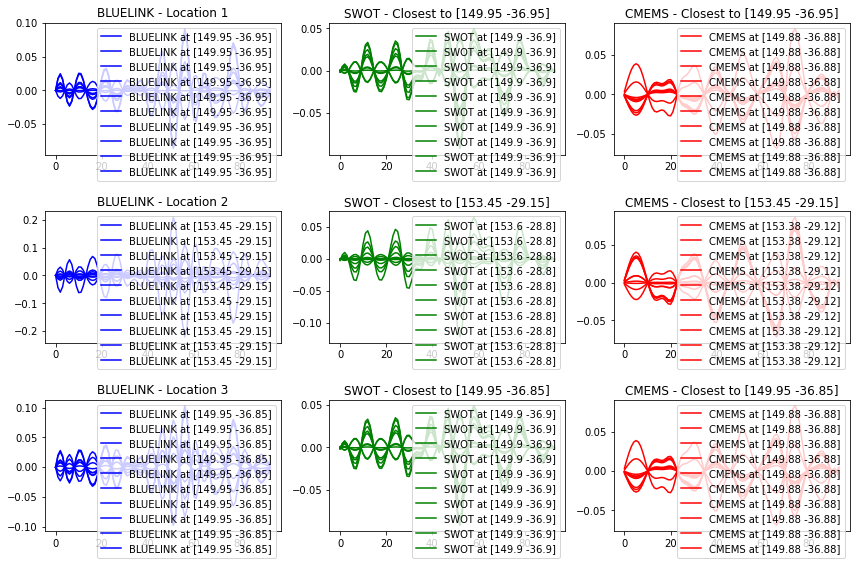

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import random

# Function to compute spatial distance between two points
def spatial_distance(loc1, loc2):
    """
    Compute the spatial distance (in degrees) between two locations.
    
    Parameters:
        loc1 (tuple): Latitude and longitude of the first location.
        loc2 (tuple): Latitude and longitude of the second location.
        
    Returns:
        float: The spatial distance between the two points.
    """
    return np.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

# Function to reconstruct the signal at a specific grid point from spatial EOF and temporal PC
def reconstruct_signal(spatial_eof, temporal_pc):
    """
    Reconstruct the signal at a specific location from the first spatial EOF and first temporal PC.
    
    Parameters:
        spatial_eof (array): The first spatial EOF (1D array).
        temporal_pc (array): The first temporal PC (1D array).
        
    Returns:
        array: The reconstructed signal (1D array).
    """
    # Ensure spatial_eof and temporal_pc are aligned by expanding the dimensions to match time
    return np.outer(temporal_pc, spatial_eof)

# Load CEOF data (assuming that 'spatial_eofs' and 'temporal_pcs' are available from the pickle files)
# Here we assume you already loaded the data using the previous code.

# Randomly choose 3 grid points from the BLUELINK grid points
random_indices = random.sample(range(bluelink_ceof_data['grid_points'].shape[0]), 3)
selected_bluelink_points = bluelink_ceof_data['grid_points'][random_indices]

# Find the closest corresponding points in the SWOT and CMEMS grids
def find_closest_points(selected_points, target_grid_points):
    """
    Find the closest grid points in the target dataset.
    
    Parameters:
        selected_points (array): The selected points for comparison.
        target_grid_points (array): The grid points from the target dataset (SWOT or CMEMS).
        
    Returns:
        array: The indices of the closest points in the target grid.
    """
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(target_grid_points)
    _, indices = nbrs.kneighbors(selected_points)
    return indices.flatten()

selected_grid_points_swot = swot_ceof_data['grid_points']
selected_grid_points_cmems = cmems_ceof_data['grid_points']

# Find the closest points in SWOT and CMEMS datasets
closest_swot_indices = find_closest_points(selected_bluelink_points, swot_ceof_data['grid_points'])
closest_cmems_indices = find_closest_points(selected_bluelink_points, cmems_ceof_data['grid_points'])

# Extract the first spatial EOF and first temporal PC for each dataset
spatial_eofs_bluelink = bluelink_ceof_data['spatial_eofs']
temporal_pcs_bluelink = bluelink_ceof_data['temporal_pcs']

spatial_eofs_swot = swot_ceof_data['spatial_eofs']
temporal_pcs_swot = swot_ceof_data['temporal_pcs']

spatial_eofs_cmems = cmems_ceof_data['spatial_eofs']
temporal_pcs_cmems = cmems_ceof_data['temporal_pcs']

# Extract the first EOF mode (mode 0) for each dataset
temporal_pcs_1_bluelink = temporal_pcs_bluelink[0, :]
temporal_pcs_1_swot = temporal_pcs_swot[0, :]
temporal_pcs_1_cmems = temporal_pcs_cmems[0, :]

# Reconstruct the signals for each dataset at the selected locations
reconstructed_signals_bluelink = []
reconstructed_signals_swot = []
reconstructed_signals_cmems = []

for idx in range(3):
    # BLUELINK reconstructed signal
    reconstructed_signals_bluelink.append(reconstruct_signal(spatial_eofs_bluelink[random_indices[idx], :], temporal_pcs_1_bluelink))
    
    # SWOT reconstructed signal at the closest point
    reconstructed_signals_swot.append(reconstruct_signal(spatial_eofs_swot[closest_swot_indices[idx], :], temporal_pcs_1_swot))
    
    # CMEMS reconstructed signal at the closest point
    reconstructed_signals_cmems.append(reconstruct_signal(spatial_eofs_cmems[closest_cmems_indices[idx], :], temporal_pcs_1_cmems))

# Plot the reconstructed signals for each dataset
plt.figure(figsize=(12, 8))

for i in range(3):
    # Plot BLUELINK signal
    plt.subplot(3, 3, i * 3 + 1)
    plt.plot(reconstructed_signals_bluelink[i], label=f'BLUELINK at {selected_bluelink_points[i]}', color='blue')
    plt.legend()
    plt.title(f'BLUELINK - Location {i + 1}')
    
    # Plot SWOT signal
    plt.subplot(3, 3, i * 3 + 2)
    plt.plot(reconstructed_signals_swot[i], label=f'SWOT at {selected_grid_points_swot[closest_swot_indices[i]]}', color='green')
    plt.legend()
    plt.title(f'SWOT - Closest to {selected_bluelink_points[i]}')
    
    # Plot CMEMS signal
    plt.subplot(3, 3, i * 3 + 3)
    plt.plot(reconstructed_signals_cmems[i], label=f'CMEMS at {selected_grid_points_cmems[closest_cmems_indices[i]]}', color='red')
    plt.legend()
    plt.title(f'CMEMS - Closest to {selected_bluelink_points[i]}')

plt.tight_layout()
plt.show()


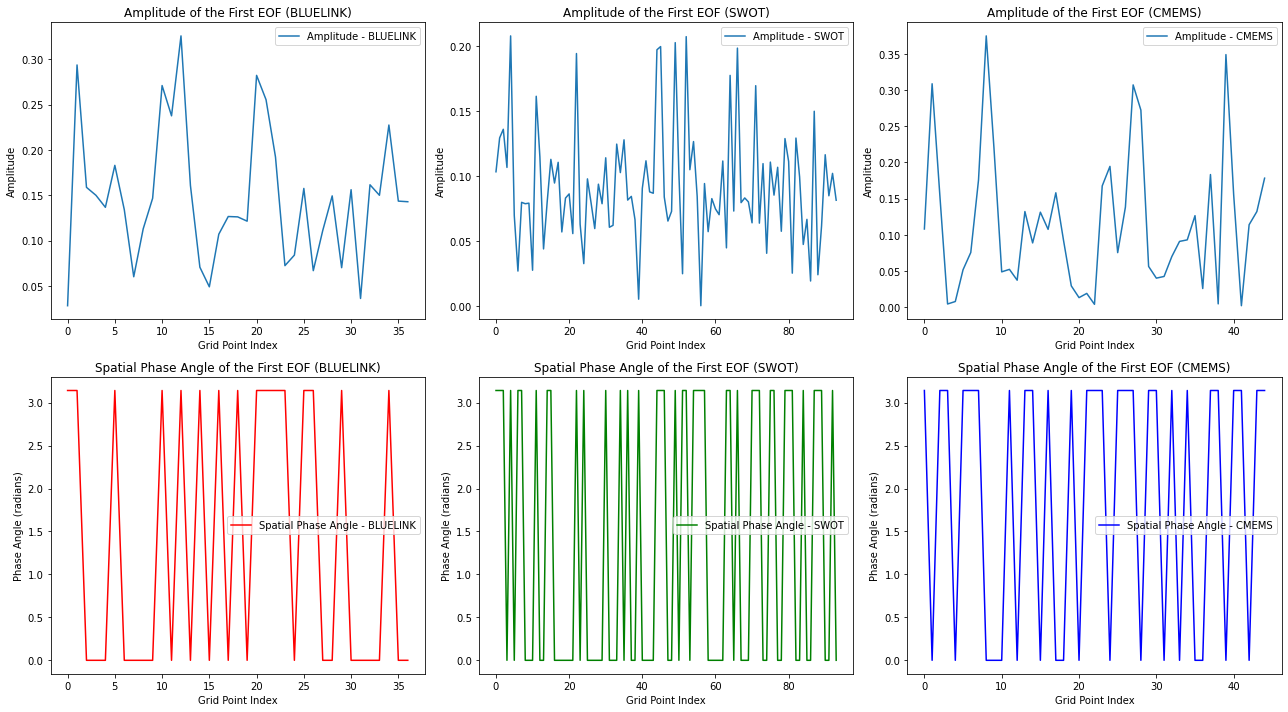

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming spatial_eofs are stored as (num_grid_points, num_modes)
# Extract the first spatial EOF for each dataset (the first column for each dataset)
spatial_eofs_bluelink_first = spatial_eofs_bluelink[:, 0]
spatial_eofs_swot_first = spatial_eofs_swot[:, 0]
spatial_eofs_cmems_first = spatial_eofs_cmems[:, 0]

# Calculate the amplitude and phase for each dataset's first EOF (spatial EOFs)
amplitude_bluelink = np.abs(spatial_eofs_bluelink_first)
amplitude_swot = np.abs(spatial_eofs_swot_first)
amplitude_cmems = np.abs(spatial_eofs_cmems_first)

# Compute the spatial phase angle for each dataset's first EOF (spatial phase)
phase_angle_bluelink = np.angle(spatial_eofs_bluelink_first)
phase_angle_swot = np.angle(spatial_eofs_swot_first)
phase_angle_cmems = np.angle(spatial_eofs_cmems_first)

# Plot the amplitude and spatial phase angle for each dataset
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot Amplitude
axes[0, 0].plot(amplitude_bluelink, label='Amplitude - BLUELINK')
axes[0, 0].set_title('Amplitude of the First EOF (BLUELINK)')
axes[0, 0].set_xlabel('Grid Point Index')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].legend()

axes[0, 1].plot(amplitude_swot, label='Amplitude - SWOT')
axes[0, 1].set_title('Amplitude of the First EOF (SWOT)')
axes[0, 1].set_xlabel('Grid Point Index')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].legend()

axes[0, 2].plot(amplitude_cmems, label='Amplitude - CMEMS')
axes[0, 2].set_title('Amplitude of the First EOF (CMEMS)')
axes[0, 2].set_xlabel('Grid Point Index')
axes[0, 2].set_ylabel('Amplitude')
axes[0, 2].legend()

# Plot Spatial Phase Angle
axes[1, 0].plot(phase_angle_bluelink, label='Spatial Phase Angle - BLUELINK', color='red')
axes[1, 0].set_title('Spatial Phase Angle of the First EOF (BLUELINK)')
axes[1, 0].set_xlabel('Grid Point Index')
axes[1, 0].set_ylabel('Phase Angle (radians)')
axes[1, 0].legend()

axes[1, 1].plot(phase_angle_swot, label='Spatial Phase Angle - SWOT', color='green')
axes[1, 1].set_title('Spatial Phase Angle of the First EOF (SWOT)')
axes[1, 1].set_xlabel('Grid Point Index')
axes[1, 1].set_ylabel('Phase Angle (radians)')
axes[1, 1].legend()

axes[1, 2].plot(phase_angle_cmems, label='Spatial Phase Angle - CMEMS', color='blue')
axes[1, 2].set_title('Spatial Phase Angle of the First EOF (CMEMS)')
axes[1, 2].set_xlabel('Grid Point Index')
axes[1, 2].set_ylabel('Phase Angle (radians)')
axes[1, 2].legend()

plt.tight_layout()
plt.show()


In [ ]:
np.shape(spatial_eofs_bluelink)

In [ ]:
bluelink_ceof_data = load_ceof_data(bluelink_ceof_file)

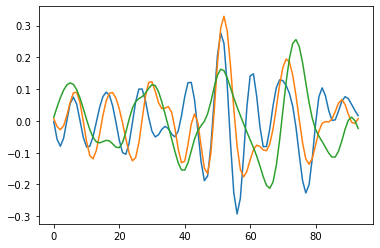

In [56]:
plt.plot(temporal_pcs_bluelink[0,:])
plt.plot(temporal_pcs_swot[0,:])
plt.plot(temporal_pcs_cmems[0,:])

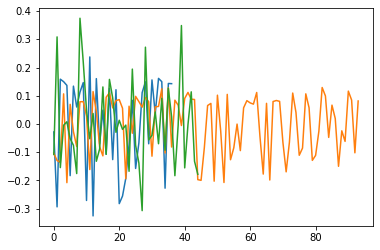

In [59]:
plt.plot(spatial_eofs_bluelink[:,0])
plt.plot(spatial_eofs_swot[:,0])
plt.plot(spatial_eofs_cmems[:,0])